# Geometric Accuracy of Sentinel-1 NRB sample product

This notebooks uses Sentinel-1 NRB sample product generated over Australian corner reflector array site to measure the geometric accuracy of the product.

### Prepare input data

In [1]:
!ls ../../S1_samples

 20200912
 Australia_SH_2019_10_11.zip
 Australia_SH_2019.zip
 QLD_corner_reflector_positions_GDA2020.txt
 QLD_corner_reflector_positions_GDA2020.xlsx
 Untitled.ipynb
'Updated Queensland_CR_information for CEOS Point Targets.xlsx'


In [2]:
# unzip data if necessary

#from zipfile import ZipFile

#with ZipFile('../../S1_samples/Australia_SH_2019_10_11.zip', 'r') as zipObj:
#   # Extract all the contents of zip file in current directory
#   zipObj.extractall()

### Load S1 sample data

HH band is available in ascending pass.

In [1]:
%matplotlib inline

import numpy as np
import xarray as xr
import os, glob
from matplotlib import pyplot as plt

In [2]:
# sinergise sample

def load_s1_sample_combined(s1_sample_path, band):
    fnames = glob.glob(f"{s1_sample_path}/**/*_{band}.tif", recursive=True)
    data = []
    for fname in fnames:
        date = np.datetime64('-'.join(fname.split('/')[-1].split('/')[-1].split('_')[4:7]))
        data.append(xr.open_rasterio(fname, chunks={'x':1000, 'y':1000}).squeeze().to_dataset(name=band).expand_dims({'time':[date]}))
    dtype = data[0][band].dtype
    return xr.combine_by_coords(data).astype(dtype).sortby('time')

In [3]:
combined = load_s1_sample_combined('s1_nrb', 'HH')

In [6]:
combined

,Array,Chunk
Bytes,6.00 GB,4.00 MB
Shape,"(5, 15000, 20000)","(1, 1000, 1000)"
Count,9060 Tasks,1500 Chunks
Type,float32,numpy.ndarray


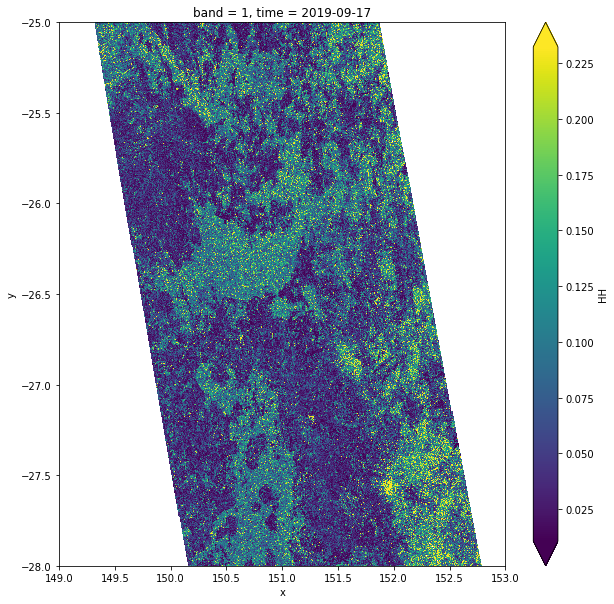

In [7]:
# quick visual check

combined.HH.isel(time=0).plot.imshow(robust=True, figsize=(10,10));

In [8]:
#combined.MASK.squeeze().plot.imshow(robust=True, figsize=(10,10));

In [9]:
#(combined.ANGLE*254.55/360).where(combined.ANGLE<255).squeeze().plot.imshow(robust=True, figsize=(10,10));

In [10]:
#combined.AREA.squeeze().plot.imshow(robust=True, figsize=(10,10));

### Load corner reflector locations

In [11]:
import pandas as pd

In [12]:
cr_locations = pd.read_csv('../../S1_samples/QLD_corner_reflector_positions_GDA2020.txt', sep="\s+", header=0)

In [13]:
cr_locations.head()

,Name,Latitude,Longitude,Height,X,Y,Z,veloX,veloY,veloZ,Azimuth,Elevation
0,SB01-CRApex,-26.834710,151.165604,409.4544,-4.989394e+06,2.746844e+06,-2.862070e+06,-0.0325,-0.0083,0.0487,257.10,53.32
1,SB02-CRApex,-26.951633,151.237613,432.7094,-4.987723e+06,2.737762e+06,-2.873636e+06,-0.0325,-0.0082,0.0486,256.21,53.33
2,SB03-CRApex,-27.100732,151.258809,391.8599,-4.982121e+06,2.732289e+06,-2.888335e+06,-0.0326,-0.0081,0.0485,258.46,54.34
3,SB04-CRApex,-27.308871,151.271959,385.2420,-4.973496e+06,2.726074e+06,-2.908845e+06,-0.0326,-0.0079,0.0484,258.51,54.67
4,SB05-CRApex,-27.456930,151.190830,403.0057,-4.963033e+06,2.729485e+06,-2.923422e+06,-0.0327,-0.0077,0.0484,258.20,55.36


In [14]:
col_lat = [n for n in list(cr_locations.columns) if 'Latitude' in n]
col_lon = [n for n in list(cr_locations.columns) if 'Longitude' in n]

In [15]:
cr_locations= cr_locations[cr_locations[col_lat].notnull().values & cr_locations[col_lon].notnull().values]

In [16]:
len(cr_locations)

40

### Extract backscatter around each CR

In [17]:
hs = 0.0008

data_crs = []

ntime = len(combined.time)
for i in range(ntime):
    s1 = combined.HH.isel(time=0).compute()

    for idx, row in cr_locations.iterrows():
        try:
            # is the CR in the scene?
            d = s1.sel(x = row[col_lon].values[0], y = row[col_lat].values[0], method='nearest', tolerance=0.002)
            x0, y0 = d.x.values, d.y.values
            #data_crs[idx] = s1.sel(x = slice(x0-hs, x0+hs), y = slice(y0+hs, y0-hs))
            data = s1.sel(x = slice(x0-hs, x0+hs), y = slice(y0+hs, y0-hs))
            # is it visible?
            peak = data.where(data==data.max()).dropna(dim='x', how='all').dropna(dim='y', how='any')
            if peak.max()>3: 
                #print(row[col_lon].values, peak.x.values[0], row[col_lat].values, peak.y.values[0])
                data_crs.append(data)
            else:
                print("not visible?", peak.max().values)
        except KeyError:
            pass
    # 

In [18]:
len(data_crs)

200

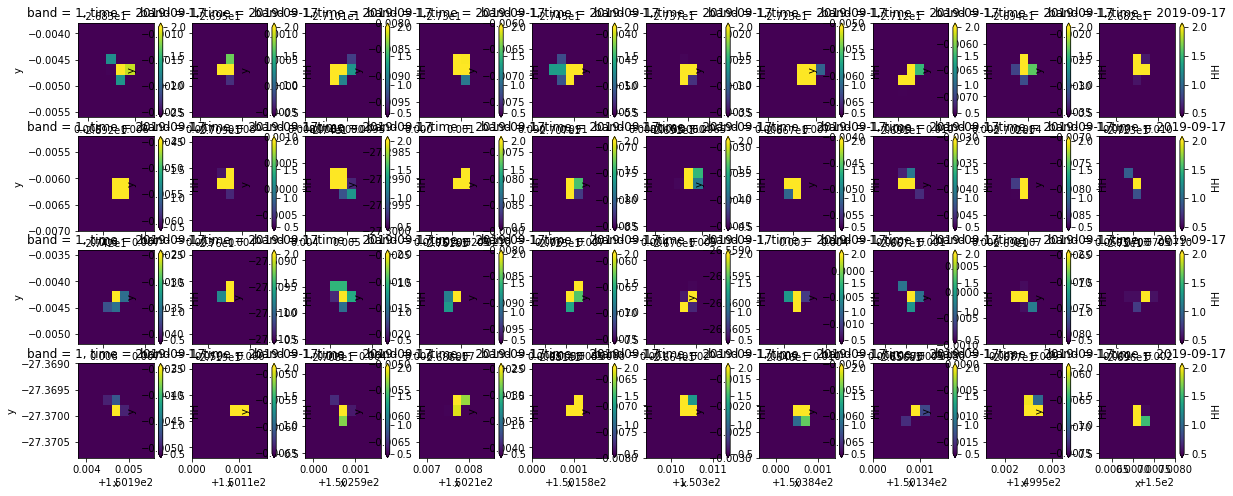

In [19]:
# visual check selected stamps

f, ax = plt.subplots(4,10,figsize=(20,8))
ax = ax.flatten()
for i in range(len(data_crs[::ntime])):
    data_crs[i].plot.imshow(ax=ax[i], vmin=0.5, vmax=2);

### Find peak backscatter in each stamp around a CR

Three methods are used:
1. center of mass measured from entire stamp
2. center of mass measured using pixels with backscatter values larger than a threshold
3. cetroild measured from a 2d gaussian fit

In [20]:
#!pip install photutils --user

In [21]:
from photutils.centroids import centroid_2dg

In [22]:
from scipy import interpolate
from scipy import ndimage

In [23]:
ps = 0.0002 # pixel scale in degree
mpd_lat = 111.32*1000 # meter per degree lat
mpd_lon = 111.32*1000*np.cos(cr_locations.Latitude.values.max()*np.pi/180.) # maximum meter per degree lon
mpd_lon +=111.32*1000*np.cos(cr_locations.Latitude.values.min()*np.pi/180.) #for minimum meter per degree lon
mpd_lon /=2.

#### Center of mass using all pixels

In [24]:
# center of mass all pixel

c_lats = []
c_lons = []
for i in range(len(data_crs)):
    
    # center of mass
    fx = interpolate.interp1d(np.arange(len(data_crs[i].x)), data_crs[i].x.values)
    fy = interpolate.interp1d(np.arange(len(data_crs[i].y)), data_crs[i].y.values)
    x, y = ndimage.measurements.center_of_mass(data_crs[i].values)
    c_lon, c_lat = fx(x), fy(y)
    
    c_lats.append(c_lat)
    c_lons.append(c_lon)

print("RMSE Latitude (pixel)", np.sqrt(np.mean((np.tile(cr_locations.Latitude.values, ntime) - c_lats)**2))/ps)
print("RMSE Longitude (pixel)", np.sqrt(np.mean((np.tile(cr_locations.Longitude.values, ntime) - c_lons)**2))/ps)    
print("RMSE Latitude (meter)", np.sqrt(np.mean((np.tile(cr_locations.Latitude.values, ntime) - c_lats)**2))*mpd_lat)
print("RMSE Longitude (meter)", np.sqrt(np.mean((np.tile(cr_locations.Longitude.values, ntime) - c_lons)**2))*mpd_lon)

RMSE Latitude (pixel) 0.39453261056975786
RMSE Longitude (pixel) 0.43759509161821336
RMSE Latitude (meter) 8.78387404172509
RMSE Longitude (meter) 8.677464788974712


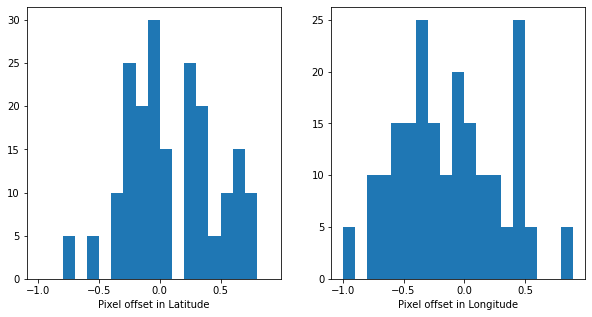

In [25]:
f, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].hist((np.tile(cr_locations.Latitude.values, ntime) - c_lats)/ps, bins=np.arange(-1,1,0.1));
ax[0].set_xlabel('Pixel offset in Latitude');
ax[1].hist((np.tile(cr_locations.Longitude.values, ntime) - c_lons)/ps, bins=np.arange(-1,1,0.1));
ax[1].set_xlabel('Pixel offset in Longitude');

#### Center of mass using pixels with backscatter >1

In [26]:
# center of mass high backscatter pixels

c_lats = []
c_lons = []
for i in range(len(data_crs)):
    
    # center of mass
    fx = interpolate.interp1d(np.arange(len(data_crs[i].x)), data_crs[i].x.values)
    fy = interpolate.interp1d(np.arange(len(data_crs[i].y)), data_crs[i].y.values)
    x, y = ndimage.measurements.center_of_mass(data_crs[i].where(data_crs[i]>1,0).values)
    c_lon, c_lat = fx(x), fy(y)

    c_lats.append(c_lat)
    c_lons.append(c_lon)

    
print("RMSE Latitude (pixel)", np.sqrt(np.mean((np.tile(cr_locations.Latitude.values, ntime) - c_lats)**2))/ps)
print("RMSE Longitude (pixel)", np.sqrt(np.mean((np.tile(cr_locations.Longitude.values, ntime) - c_lons)**2))/ps)    
print("RMSE Latitude (meter)", np.sqrt(np.mean((np.tile(cr_locations.Latitude.values, ntime) - c_lats)**2))*mpd_lat)
print("RMSE Longitude (meter)", np.sqrt(np.mean((np.tile(cr_locations.Longitude.values, ntime) - c_lons)**2))*mpd_lon)

RMSE Latitude (pixel) 0.4576376628586074
RMSE Longitude (pixel) 0.47324008555202207
RMSE Latitude (meter) 10.188844925884036
RMSE Longitude (meter) 9.384301281632867


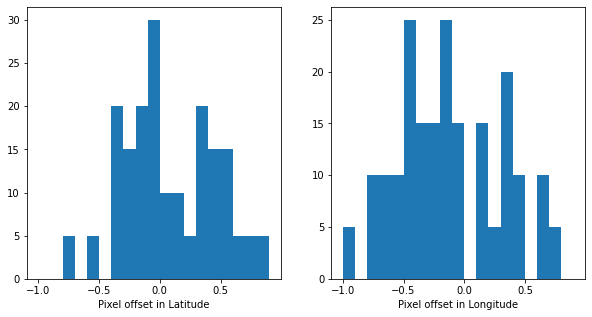

In [27]:
f, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].hist((np.tile(cr_locations.Latitude.values, ntime) - c_lats)/ps, bins=np.arange(-1,1,0.1));
ax[0].set_xlabel('Pixel offset in Latitude');
ax[1].hist((np.tile(cr_locations.Longitude.values, ntime) - c_lons)/ps, bins=np.arange(-1,1,0.1));
ax[1].set_xlabel('Pixel offset in Longitude');

#### Cetroild measured from a 2d gaussian fit

In [28]:
# gaussian centroid 

c_lats = []
c_lons = []
for i in range(len(data_crs)):
    
    # gaussian centroid
    fx = interpolate.interp1d(np.arange(len(data_crs[i].x)), data_crs[i].x.values)
    fy = interpolate.interp1d(np.arange(len(data_crs[i].y)), data_crs[i].y.values)
    x, y = centroid_2dg(data_crs[i].values)
    c_lon, c_lat = fx(x), fy(y)
    
    c_lats.append(c_lat)
    c_lons.append(c_lon)

    
print("RMSE Latitude (pixel)", np.sqrt(np.mean((np.tile(cr_locations.Latitude.values, ntime) - c_lats)**2))/ps)
print("RMSE Longitude (pixel)", np.sqrt(np.mean((np.tile(cr_locations.Longitude.values, ntime) - c_lons)**2))/ps)    
print("RMSE Latitude (meter)", np.sqrt(np.mean((np.tile(cr_locations.Latitude.values, ntime) - c_lats)**2))*mpd_lat)
print("RMSE Longitude (meter)", np.sqrt(np.mean((np.tile(cr_locations.Longitude.values, ntime) - c_lons)**2))*mpd_lon)

RMSE Latitude (pixel) 0.21949785755612547
RMSE Longitude (pixel) 0.34397726006424056
RMSE Latitude (meter) 4.886900300629578
RMSE Longitude (meter) 6.82103300422671


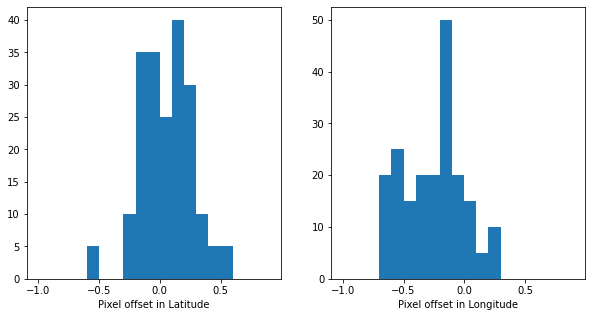

In [29]:
f, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].hist((np.tile(cr_locations.Latitude.values, ntime) - c_lats)/ps, bins=np.arange(-1,1,0.1));
ax[0].set_xlabel('Pixel offset in Latitude');
ax[1].hist((np.tile(cr_locations.Longitude.values, ntime) - c_lons)/ps, bins=np.arange(-1,1,0.1));
ax[1].set_xlabel('Pixel offset in Longitude');

### Check data generated with bilinear interpolation

In [4]:
combined_bilinear = load_s1_sample_combined('s1_nrb_bilinear', 'HH')

In [31]:
hs = 0.0008

data_crs = []

ntime = len(combined.time)
for i in range(ntime):
    s1 = combined_bilinear.HH.isel(time=0).compute()

    for idx, row in cr_locations.iterrows():
        try:
            # is the CR in the scene?
            d = s1.sel(x = row[col_lon].values[0], y = row[col_lat].values[0], method='nearest', tolerance=0.002)
            x0, y0 = d.x.values, d.y.values
            #data_crs[idx] = s1.sel(x = slice(x0-hs, x0+hs), y = slice(y0+hs, y0-hs))
            data = s1.sel(x = slice(x0-hs, x0+hs), y = slice(y0+hs, y0-hs))
            # is it visible?
            peak = data.where(data==data.max()).dropna(dim='x', how='all').dropna(dim='y', how='any')
            if peak.max()>3: 
                #print(row[col_lon].values, peak.x.values[0], row[col_lat].values, peak.y.values[0])
                data_crs.append(data)
            else:
                print("not visible?", peak.max().values)
        except KeyError:
            pass
    # 

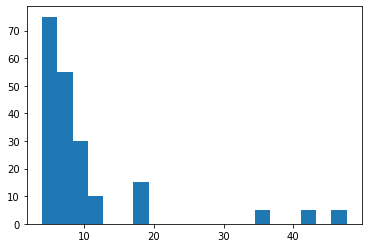

In [32]:
peaks = [d.max().values for d in data_crs]
plt.hist(peaks, bins=20);

In [33]:
# center of mass all pixel

c_lats = []
c_lons = []
for i in range(len(data_crs)):
    
    # center of mass
    fx = interpolate.interp1d(np.arange(len(data_crs[i].x)), data_crs[i].x.values)
    fy = interpolate.interp1d(np.arange(len(data_crs[i].y)), data_crs[i].y.values)
    x, y = ndimage.measurements.center_of_mass(data_crs[i].values)
    c_lon, c_lat = fx(x), fy(y)
    
    c_lats.append(c_lat)
    c_lons.append(c_lon)

print("RMSE Latitude (pixel)", np.sqrt(np.mean((np.tile(cr_locations.Latitude.values, ntime) - c_lats)**2))/ps)
print("RMSE Longitude (pixel)", np.sqrt(np.mean((np.tile(cr_locations.Longitude.values, ntime) - c_lons)**2))/ps)    
print("RMSE Latitude (meter)", np.sqrt(np.mean((np.tile(cr_locations.Latitude.values, ntime) - c_lats)**2))*mpd_lat)
print("RMSE Longitude (meter)", np.sqrt(np.mean((np.tile(cr_locations.Longitude.values, ntime) - c_lons)**2))*mpd_lon)

RMSE Latitude (pixel) 0.35561341394724744
RMSE Longitude (pixel) 0.4160041314501757
RMSE Latitude (meter) 7.9173770481215175
RMSE Longitude (meter) 8.249318312455813


In [5]:
hh_nearest = 10*np.log10(combined.HH.where(combined.HH>0))
hh_bilinear = 10*np.log10(combined_bilinear.HH.where(combined_bilinear.HH>0).where(combined_bilinear.HH<5000))

/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))
/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less
  return func(*(_execute_task(a, cache) for a in args))
/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))


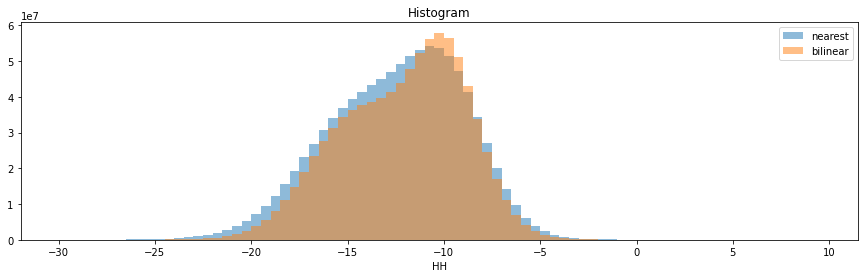

In [6]:
hh_nearest.plot.hist(bins=np.arange(-30,10,0.5), alpha=0.5, label='nearest', figsize=(15,4));
hh_bilinear.plot.hist(bins=np.arange(-30,10,0.5), alpha=0.5, label='bilinear');
plt.legend();